In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.ndimage import convolve1d
from scipy import signal as dsp
import signals

In [2]:
a = np.array([1,2,3])
b = np.array([4,5,6])  
np.dot(a,b)

32

# Signals

### sin wave with given frquency, sampling time

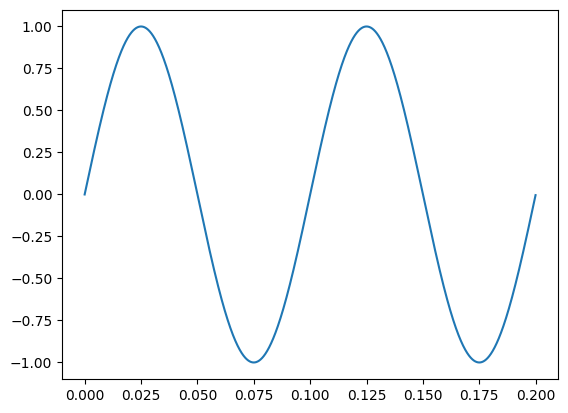

In [3]:
duration = 0.2 #s
sampling_rate = 16000 #Hz
f = 10 #hz
    
sin_wave, t = signals.create_sin_wave(f, duration, sampling_rate)

plt.plot(t, sin_wave)

# step signal

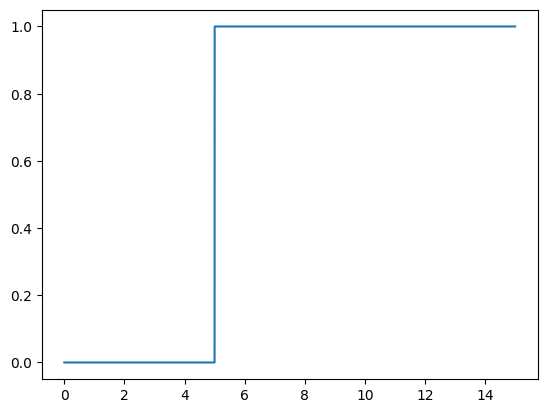

In [4]:
step_signal, t = signals.create_step_signal(5, 1, 10, 16000)
plt.plot(t, step_signal)

# Filters

## Moving average filter

In [5]:
def apply_moving_avg_filter(noisy_signal, filter_size):

    ma_filter = np.ones(filter_size)
    
    filtered_signal = dsp.convolve(noisy_signal, ma_filter, mode='same') / np.sum(ma_filter)
    
    return filtered_signal

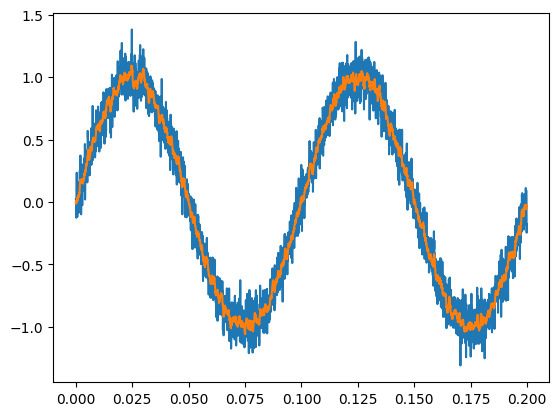

In [6]:
# create pure sine wave
sin_wave, t = signals.create_sin_wave(f, duration, sampling_rate)

# create white noise signal
mean = 0
std_dev = 0.1
noise_signal =  np.random.normal(mean,std_dev,sin_wave.size)

# add noise to pure sin wave
noisy_sin_wave = sin_wave  + noise_signal
plt.plot(t, noisy_sin_wave)

ma_filter_size = 10

filtered_signal = apply_moving_avg_filter(noisy_sin_wave, ma_filter_size)

plt.plot(t, filtered_signal)
plt.show()

## Magnitude and phase response

##  Zero Phase filtering 

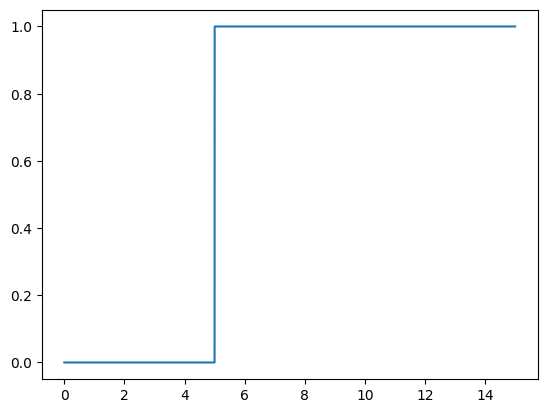

In [7]:
# create step input
step_signal, t = signals.create_step_signal(5, 1, 10, 16000)
plt.plot(t, step_signal)

# apply zerp phase filter


## Low-pass filter (Continuous time)

In [19]:
import importlib
import filter 

Mode.continuous
creating lowpass filter
Mode.continuous
creating lowpass filter


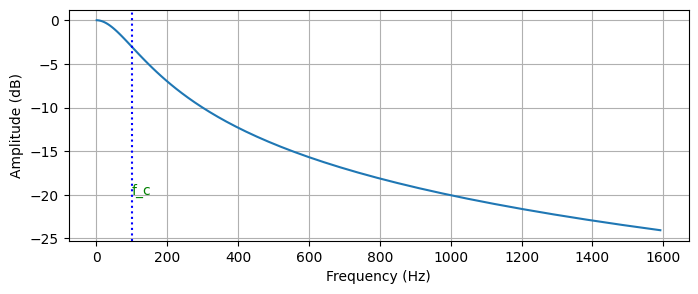

In [20]:
importlib.reload(filter)

lowpass_filter = filter.Filter(type = filter.Type.lowpass)
lowpass_filter.set_cutoff_freq_hz(100)

lowpass_filter.plot_magn_response()

Mode.continuous
creating highpass filter
Mode.continuous
creating highpass filter


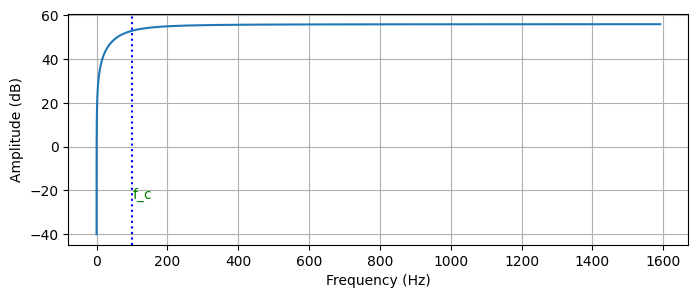

In [10]:
highpass_filter = filter.Filter(type = filter.Type.highpass)
highpass_filter.set_cutoff_freq_hz(100)

highpass_filter.plot_magn_response()